In [31]:
%load_ext autoreload
%autoreload 2 
from vpot.calc import myMolecule
from vpot.calc.grids import sphericalGrid, blockGrid, pointGrid
from vpot.calc.potential import vpot,vBpot, vpotANC
from vpot.calc import DFTGroundState
from matplotlib import pyplot as plt
from scipy.special import erf

import psi4
import numpy as np
import logging,time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
b = {1 : -3.6442293856e-01, 2 : -1.9653418982e-01, 3 : -1.3433604753e-01, 4 : -1.0200558466e-01,
     5 : -8.2208091118e-02, 6 : -6.8842555167e-02, 7 : -5.9213652850e-02, 8 : -5.1947028250e-02,
     9 : -4.6268559218e-02, 10 : -4.1708913494e-02, 11 : -3.7967227308e-02, 12 : -3.4841573775e-02}

def V(a, b, r):
    h_prime_term = h_prime(a, b, r)
    h_double_prime_term = h_double_prime(a, b, r)
    v = -0.5 + (h_prime_term / r) + (h_prime_term**2 / 2) + (h_double_prime_term / 2)
    return v

def V_Z(Z, a, b, r):
    """
    Returns the value of the V_Z function for the given parameters.

    Parameters:
        Z (float): the value of Z
        a (float): the value of a
        b (float): the value of b
        r (float): the value of r

    Returns:
        float: the value of V_Z(Z, a, b, r) = Z^2 * V(a, b, Z*r)
    """
    return Z**2 * V(a, b, Z*r)


def h(a, b, r):
    erf_term = -r * erf(a*r)
    exp_term = b * np.exp(-a**2 * r**2)
    return erf_term + exp_term

def h_prime(a, b, r):
    erf_term = -erf(a*r)
    exp_term = -2 * ((a**2) * b + (a / np.sqrt(np.pi))) * r * np.exp(-a**2 * r**2)
    return erf_term + exp_term

def h_double_prime(a, b, r):
    exp_term = (-2 * (a**2) * b - (4 * a) / np.sqrt(np.pi) 
                + (4 * (a**4) * b + (4 * (a**3)) / np.sqrt(np.pi)) * r**2) * np.exp(-a**2 * r**2)
    return exp_term



(-10.0, 0.5)

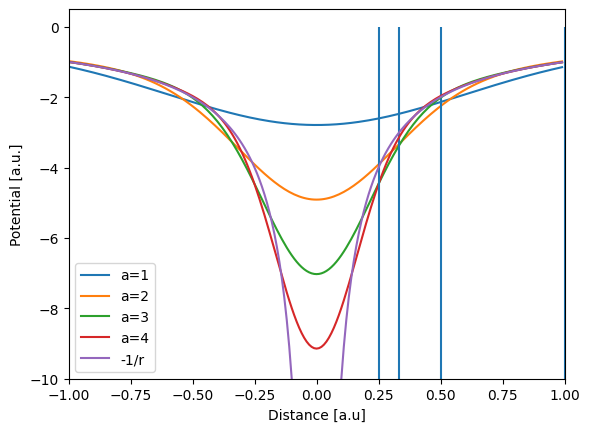

In [3]:
X = np.arange(-1.0,1.0,0.01)
Z = 1
for prec in [1,2,3,4]:
    plt.plot(X,V_Z(Z,prec,b[prec],X),label=f"a={prec}")
    plt.vlines(Z/prec,-25,0.0)
plt.plot(X,-Z/np.abs(X),label=f"-{Z}/r")
plt.legend()
plt.ylim(-Z/0.02,0)
plt.xlabel("Distance [a.u]")
plt.ylabel("Potential [a.u.]")
plt.xlim(-1.0,1.0)
plt.ylim(-10,0.5)

(-1.0, 0.0)

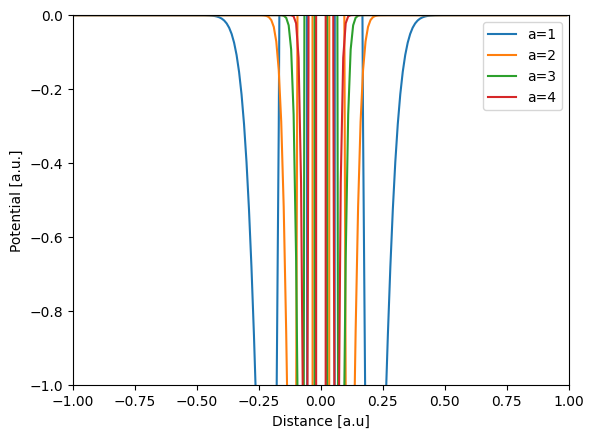

In [266]:
X = np.arange(-1.0,1.0,0.01)
Z = 8
for prec in [1,2,3,4]:
    plt.plot(X,-Z/np.abs(X) - V_Z(Z,prec,b[prec],X),label=f"a={prec}")
    plt.vlines(Z/prec,-25,0.0)
plt.legend()
plt.ylim(-Z/0.02,0)
plt.xlabel("Distance [a.u]")
plt.ylabel("Potential [a.u.]")
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,0.0)

In [33]:
def basisExp(Ds,exps,Ls,r):
    """
    This is the basis set expansion of size
    len(Ds)==len(exps)==len(Ls)
    """
    size = len(r)
    Y = np.zeros(size)
    
    for d,exp,l in zip(Ds,exps,Ls):
        Y += cgp(d,exp,l,r)
        
    return Y
    


def cgp(D,exps,l,r):
    Y = np.zeros(len(r))
    for d,exp in zip(D,exps):
        Y += d*gp(exp,l,r)
    return Y


def gp(exp,l,r):
    P = r**l
    N = 0
    if l==0:
        Ns = 1/np.sqrt(np.sqrt(2*np.pi)/(2*np.sqrt(exp)))
        N = Ns
    elif l==1:
        Np = 1/np.sqrt((np.sqrt(2)*np.sqrt(np.pi))/(8*exp**(3./2.)))
        N= Np
        
    elif l==2:
        Nd = 1/np.sqrt((3*np.sqrt(2)*np.sqrt(np.pi)/(32*exp**(5/2))))
        N = Nd
    N=1
    return P*N*np.exp(-exp*r**2)


def ANC(Atoms,prec,X):
    V = 0.0 
    for za,xa in Atoms:
        V += V_Z(za,prec,b[prec],X-xa)
    return V

(-5.0, 0.5)

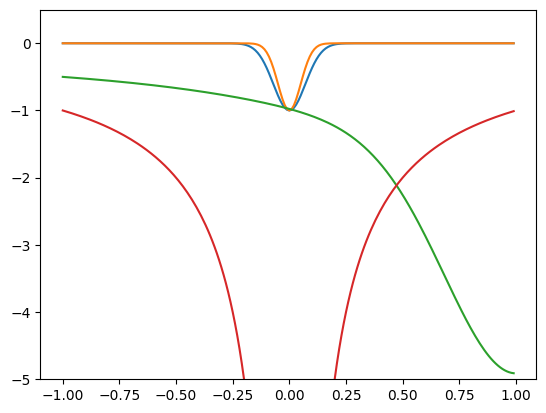

In [8]:
plt.plot(X,-gp(100,0,X))
plt.plot(X,-cgp([1],[200],0,X))
#plt.plot(X,-cgp([100],[2000],X))
plt.plot(X,ANC([(1.0,1.0)],2,X))
plt.plot(X,-1/np.abs(X))
plt.ylim(-5,0.5)

initX: [[  1.         -12.63050929]
 [ 17.5        -12.63050929]
 [ 34.         -12.63050929]
 [ 50.5        -12.63050929]
 [ 67.         -12.63050929]
 [ 83.5        -12.63050929]
 [100.         -12.63050929]
 [  1.         -12.63050929]
 [ 17.5        -12.63050929]
 [ 34.         -12.63050929]
 [ 50.5        -12.63050929]
 [ 67.         -12.63050929]
 [ 83.5        -12.63050929]
 [100.         -12.63050929]]
SUCCESS? : True
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.03969709104046003
        x: [ 1.000e+00 -1.433e+01 ...  9.908e+01 -1.235e+01]
      nit: 458
      jac: [ 2.870e-01 -7.714e-06 ...  7.078e-08 -2.831e-07]
     nfev: 14355
     njev: 495
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>


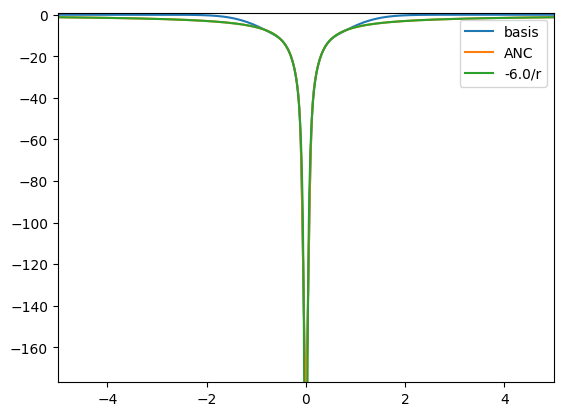

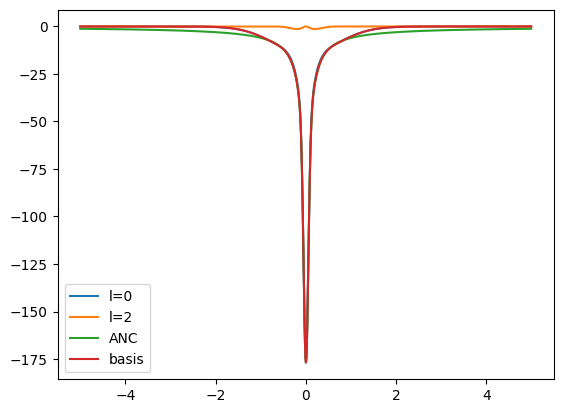

For Z=6.0 and a=2
[0,
(1.0,-0.22461786607341364),
(13.845568160602001,-0.30348092891692463),
(48.43242611411797,-0.36656785111004025),
(131.64974804239822,-0.0016706161320301477),
(150.6377170389632,-0.09895965089389915),
(184.25659020951073,-0.5024053313439563),
(196.25672530557276,-1.273674078159895),
],
[2,
(64.09059667065853,-44.32025397429442),
(16.361102033383844,-55.914609888605284),
(40.71101142609209,-0.8920479546367135),
(53.52932100771474,-15.110109753231313),
(66.53754476353657,-16.876741244067606),
(82.28764541343487,-15.266989642815647),
(99.07972731524194,-13.46462760006232),
],


In [38]:
from scipy.optimize import minimize

def DIFF(x0,Atoms,prec,L,l,X):
    
    D    =  x0.reshape(-1,2)[:,1].reshape(-1,L)
    exps =  x0.reshape(-1,2)[:,0].reshape(-1,L)
    Ls = l
    
    Xopt = np.arange(-1.0,1.0,0.005)
    Y1 = ANC(Atoms,prec,Xopt)
    Y2 = basisExp(D,exps,Ls,Xopt)
    
    return np.sum(np.square(Y1-Y2))/len(Xopt)



def plotInitialSetup(Atoms,X):
    plt.plot(X,ANC(Atoms,prec,X))
    
# Atoms are give as [(Za,Xa),(Zb,Xb)]

"""
The idea is now to input an s,p and a d function,
each is contracted with 3 expoenents and 3 contraction coefficients

"""

Atoms = [(6.0,0.0)]


L = 7
prec = 2

Z = Atoms[0][0]
Ls= [0,2]
basisSize = len(Ls)
xlen = 5.0


initX = np.zeros(basisSize*2*L).reshape(-1,2)
initX[:,0] = np.array([[np.linspace(1.0,100,L)] for i in range(len(Ls))]).flatten()
initX[:,1] = -(4.91186472473308*Z**2)/(L*len(Ls))

initX = initX.flatten()
bounds = [(1.0,100000.0) if (c%2==0) else (-1E5,0.0) for c,x in enumerate(initX) ]



"""
for i in range(basisSize):
    initX[(2*i)*L:(2*i+1)*(L)] = (-(4.91186472473308*Z**2)/L)*10**i
    for c in range((2*i+1)*(L),(2*i+2)*L):
        initX[c] = (3.80564869305321*Z**2)*(np.random.rand(1)+0.5)


Y0 = 3.0*Z**2*prec**2*b[prec] - 3.38513750128654*Z**2*prec - 0.5*Z**2
"""

    
print(f"initX: {initX.reshape(-1,2)}")

X = np.arange(-xlen,xlen,0.01)

results = minimize(DIFF,initX,args=(Atoms,prec,L,Ls,X),bounds=bounds,options={"maxfun":2000000})
print(f"SUCCESS? : {results['success']}")
print(results)

D    =  results["x"].reshape(-1,2)[:,1].reshape(-1,L)
exps =  results["x"].reshape(-1,2)[:,0].reshape(-1,L)


plt.plot(X,basisExp(D,exps,Ls,X),label="basis")
plt.plot(X,ANC(Atoms,prec,X),label="ANC")
plt.plot(X,-Z/np.abs(X),label=f"-{Z}/r")
plt.ylim(np.min(ANC(Atoms,prec,X)),1.0)
plt.xlim(-xlen,xlen)
plt.legend()
plt.show()
results

C = []

for d,exp,l in zip(D,exps,Ls):
    N = 1./np.sqrt(np.trapz(cgp(d,exp,l,X)*cgp(d,exp,l,X),X))
    C.append(1/N)
    d *=N

YBasis = np.zeros(len(X))
for c,d,exp,l in zip(C,D,exps,Ls):
    plt.plot(X,c*cgp(d,exp,l,X), label=f"l={l}")
    YBasis += c*cgp(d,exp,l,X)
    
plt.plot(X,ANC(Atoms,prec,X),label="ANC")
plt.plot(X,YBasis,label="basis")

plt.legend()

plt.show()


print(f"For Z={Z} and a={prec}")

for l,d,exp in zip(Ls,D,exps):
    print(f"[{l},",)
    for i,j in zip(d,exp):
        print(f"({j},{i}),")
    print("],")
    
     




# Try with p functions

initX: [-4.91186472 -4.91186472 -4.91186472  1.99619997  5.2215742   4.49047686]
SUCCESS? : True


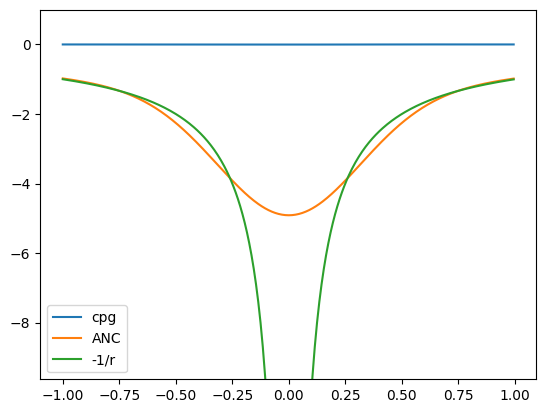

[ 0.10633265 -0.11957218  0.00957   ]
[-0.66334006  0.74593281 -0.05970099]
-0.1602988601589935


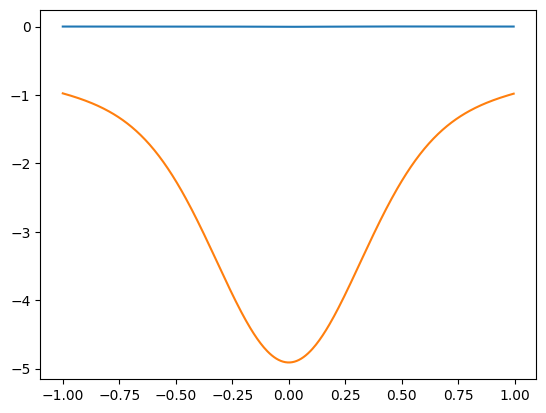

For Z=1, a=2
coeffs: [-0.66334006  0.74593281 -0.05970099]
exps:  [6.79203834 7.13181587 6.90395273]
(6.792038344415905,-0.6633400557137153),
(7.131815870715104,0.7459328137742444),
(6.90395272668907,-0.05970098676373365),


In [301]:
from scipy.optimize import minimize

def DIFF(x0,Z,prec,L,X):
    
    D    = x0[:L]
    exps = x0[L:]
    Y1 = ANC(Z,prec,X)
    Y2 = cgpp(D,exps,X)
    
    return np.sum(np.square(Y1-Y2))/len(X)

L = 3
Z = 1
prec = 2

xlen = 1.0


Y0 = 3.0*Z**2*prec**2*b[prec] - 3.38513750128654*Z**2*prec - 0.5*Z**2

initX = np.zeros(2*L)
initX[:L] = -(4.91186472473308*Z**2)

for c,i in enumerate(initX[L:]):
    initX[L+c] = (3.80564869305321*Z**2)*(np.random.rand(1)+0.5)
    
print(f"initX: {initX}")

X = np.arange(-xlen,xlen,0.005)

results = minimize(DIFF,initX,args=(Z,prec,L,X))
print(f"SUCCESS? : {results['success']}")

plt.plot(X,cgp(results["x"][:L],results["x"][L:],X),label="cpg")
plt.plot(X,ANC(Z,prec,X),label="ANC")
plt.plot(X,-Z/np.abs(X),label=f"-{Z}/r")
plt.ylim(Y0,1.0)
plt.legend()
plt.show()
results

coeffs = np.array(results["x"][:L])
exps   = np.array(results["x"][L:])
print(coeffs)
np.linalg.norm(coeffs)


prefac = -np.linalg.norm(coeffs)
coeffs /= -np.linalg.norm(coeffs)

print(coeffs)
print(prefac)

plt.plot(X,prefac*cgp(coeffs,exps,X))
plt.plot(X,ANC(Z,prec,X),label="ANC")

plt.show()

print(f"For Z={Z}, a={prec}")

print(f"coeffs: {coeffs}")
print(f"exps:  {exps}")

for e,c in zip(exps,coeffs):
    print(f"({e},{c}),")

In [7]:


def testSpericalAtomicGridCoeff(atomType="C",Molecule = None):
    from scipy.optimize import minimize
    from vpot.calc.grids import sphericalAtomicGrid
    from psi4.driver import qcdb
    
    def getCoeffsAndExps(basisDict,atomType):
        out = []
        for i in basisDict["shell_map"]:
            if i[0] == atomType:
                for j in i[2:]:
                    for k in j[1:]:
                        out.append(k)
        return(out)

    def optmizeBasis(x0,Gs,atomType):
        optmizeBasis.counter+=1
        xmod = x0
        counter = 0
        a,newBasis = qcdb.BasisSet.pyconstruct(Gs.mol.psi4Mol.to_dict(),'BASIS', 
                                               "def2-SVP",fitrole='ORBITAL',
                                              other=None,return_dict=True,return_atomlist=False)

        for i in newBasis["shell_map"]:
            del i[2:]

        for c,i in enumerate(Gs.mol.basisDict["shell_map"]):
            if i[0] == atomType:
                for j in i[2:]:
                    newBas = []
                    newBas.append(j[0])
                    for k in j[1:]:
                        newBas.append((xmod[counter],xmod[counter+1]))
                        counter+=2
                    newBasis["shell_map"][c] += [newBas]

        Gs.mol.setBasisDict(newBasis,quiet=True)
        logging.info(getCoeffsAndExps(M.basisDict,atomType))

        Gs.projectBasis()
        Vs = Gs.optimizeBasis(potentialType="anc",a=2)
        Error = Gs.getMSError(Vs)

        logging.info(f"ERROR FROM AUGMENTBASIS: {Error}")
        logging.info(getCoeffsAndExps(M.basisDict,atomType))

        if (optmizeBasis.counter %1000)==0:
            print(f"Count: {optmizeBasis.counter}, Error {Error}")
        return Error

    
    atomType = atomType.upper()
    if Molecule is None:
        M = myMolecule("tests/CH3Cl.xyz","")
    else:
        M = Molecule
    Gas = sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=1.2,nRadial=300,nSphere=590,pruningScheme="None") 
    Vas = Gas.optimizeBasis(potentialType="anc",a=2)
    Gas.printStats(Vas)
    Gas.exportErrorVsDistance(Vas)
    
    
    xinit = np.array(getCoeffsAndExps(M.basisDict,atomType))
    xinit = xinit.flatten()
    
    bounds = [(0.1,100000.0) if (c%2==0) else (None,None) for c,x in enumerate(xinit) ]

    optmizeBasis.counter=0
    result = minimize(optmizeBasis,xinit,args=(Gas,atomType),bounds=bounds)
    
    print(result)

    return result,M

Creating a spherical grid for atomtype H


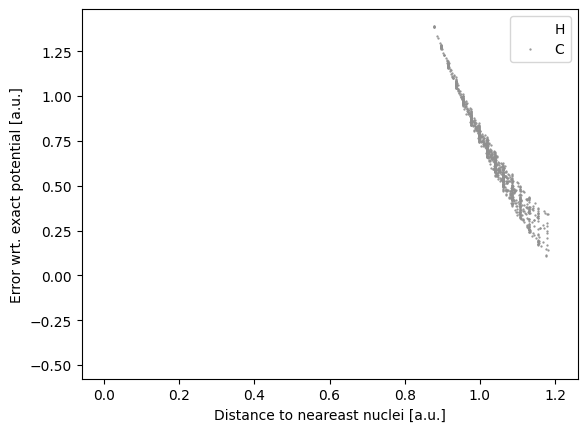

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.009036189340832473
        x: [ 5.405e+00  6.820e-01 ...  1.000e-01  2.043e+00]
      nit: 13
      jac: [ 0.000e+00  0.000e+00 ...  2.783e-02  3.266e-06]
     nfev: 592
     njev: 16
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>


In [26]:
plt.style.use("dark_background")
res,M = testSpericalAtomicGridCoeff("H",Molecule=M)

In [25]:
M.bastyleDict

{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 2   entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['C', '72db9a94c8f274aebf4410505c2208131fe6a66b'],
  ['CL', '3639ab98fc0f5e64dafb43e8b43524c0e027c969'],
  ['H',
   'a6d5fb68e49b46b6bbd6220d50dcb28b38bba2ff',
   [0,
    (5.405316891299325, 0.6820129648915216),
    (4.888708126704825, 0.5266237600075427),
    (0.4225473780551931, 0.5074699312426245)],
   [2,
    (5.405316891299325, 0.6820129648915216),
    (4.888708126704825, 0.5266237600075427),
    (0.4225473780551931, 0.5074699312426245)]],
  ['H',
   'a6d5fb68e49b46b6bbd622